In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import Butterfly_identification.preprocessbutterfly as preproc
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import CategoricalAccuracy

from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from os.path import join, sep
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.strings import split
from tensorflow.io import decode_jpeg, read_file
from tensorflow import argmax
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
import gc
from tensorflow.compat.v1 import ConfigProto , Session, InteractiveSession
from tensorflow.compat.v1.keras.backend import set_session

In [4]:
from tensorflow.data.experimental import cardinality
from IPython.display import Audio
from IPython.display import Audio
sound_file = 'treasure.mp3' #un son dans votre ordi ou une url


In [5]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(Session(config=config));
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2021-08-31 10:42:29.281302: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-31 10:42:29.867983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 10:42:30.869959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 10:42:30.871439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Get Data

In [47]:
df_train,df_val,df_test = preproc.get_data()

In [49]:
df_train.shape

(36536, 15)

In [50]:
df_train, df_val, df_test = preproc.feature_engineering(df_train, df_val, df_test)

## Generator implementation

In [51]:
PATH_TRAIN = '/home/zac/code/Em3line/Butterfly_identification/raw_data/IGM_labels/Train/'
PATH_VAL = '/home/zac/code/Em3line/Butterfly_identification/raw_data/IGM_labels/Val/'
PATH_TEST = '/home/zac/code/Em3line/Butterfly_identification/raw_data/IGM_labels/Test/'

In [52]:
df_train = preproc.get_data_minphoto(df_train)
df_train = preproc.resampling(df_train)

In [88]:
df_train.iloc[0]

author                                                       Stichel, 1912
barcode                                                    ETHZ-ENT0006752
country                                                        Switzerland
dec_lat                                                          46.793029
dec_long                                                          9.821343
family                                                        Papilionidae
genus                                                           Parnassius
image_name                                ETHZ_ENT01_2017_03_16_003602.JPG
image_path               Parnassius_apollo/ETHZ_ENT01_2017_03_16_003602...
infraspecific_epithet                                                 None
primary_division                                                   Grisons
specific_epithet                                                    apollo
subfamily                                                     Parnassiinae
subspecific_epithet      

In [11]:
df_val = preproc.filter_val_test(df_train, df_val)
df_test = preproc.filter_val_test(df_train, df_test)

In [56]:
df_train['full_path'] = df_train['species']+'/'+df_train['image_name']
df_val['full_path'] = df_val['species']+'/'+df_val['image_name']
df_test['full_path'] = df_test['species']+'/'+df_test['image_name']

In [13]:
black_list = list(PATH_TRAIN + df_train['full_path'])
black_list_val = list(PATH_VAL + df_val['full_path'])
black_list_test = list(PATH_TEST + df_test['full_path'])

In [14]:
train_names = df_train['species'].drop_duplicates()

In [95]:
test_predict = df_train['full_path'][0]

In [94]:
test_predict

'Parnassius_apollo/ETHZ_ENT01_2017_03_15_003015.JPG'

In [16]:
del df_train
del df_val
del df_test

In [17]:
filtered_train = [join(PATH_TRAIN, species) for species in black_list]
filtered_val = [join(PATH_VAL, species) for species in black_list_val]
filtered_test = [join(PATH_TEST, species) for species in black_list_test]

In [18]:
train_ds = Dataset.from_tensor_slices(filtered_train)
val_ds = Dataset.from_tensor_slices(filtered_val)
test_ds = Dataset.from_tensor_slices(filtered_test)

2021-08-31 10:42:50.335950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 10:42:50.336626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 10:42:50.337133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 10:42:50.337928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 10:42:50.338447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [19]:
del filtered_train
del filtered_test
del filtered_val

In [20]:
def get_label(file_path,class_names=train_names):
  # convert the path to a list of path components
  parts = split(file_path, sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return argmax(one_hot)

In [21]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = decode_jpeg(img, channels=3)
    img = preprocess_input(img)
    # resize the image to the desired size
    return img


In [22]:
def process_path(file_path, class_names=train_names):
    label = get_label(file_path, class_names)
    # load the raw data from the file as a string
    img = read_file(file_path)
    img = decode_img(img)
    return img, label

In [23]:
AUTOTUNE = AUTOTUNE

In [24]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [99]:
image, label = next(iter(train_ds))
label

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([22,  5, 24, 29, 30, 34, 20,  0, 23, 16, 27, 28,  0, 15, 21,  2, 22,
        9, 26, 29, 16, 17, 23, 29, 32, 12, 35, 24,  0, 31, 35,  6])>

In [25]:
def configure_for_performance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [26]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

# Data Augmentation

In [27]:
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
IMG_SIZE = 128

resize_and_rescale = Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])


In [29]:
train_ds

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.uint8, tf.int64)>

#augmentation = ImageDataGenerator(rotation_range=25, width_shift_range=0.2,
                  height_shift_range=0.2,  
                  zoom_range=0.1, horizontal_flip=True)

In [30]:
batch_size = 32
def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)


In [31]:
#train_ds = prepare(train_ds, shuffle=False, augment=True)

image_batch, label_batch = next(iter(train_ds))
print(len(label_batch))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    print(image_batch.shape)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(train_names[label])
    plt.axis("off")

In [32]:
#train_ds = train_ds.map(augmentation.flow, num_parallel_calls=AUTOTUNE)

In [33]:
# y_train = list(map(lambda x: x[1].numpy(), train_ds))

In [34]:
# pd.DataFrame(y_train).max()

In [35]:
# y_train

# Model

In [36]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
def model_VGG16(train_ds, val_ds, test_ds, image_size=(128, 128, 3),  patience=10, learning_rate=0.001, nb_epochs=15, nb_couches_dense_layer=130):
    
    model = VGG16(weights="imagenet", include_top=False, input_shape = image_size)
    
    



    model.trainable = False
    
    #add last layers
    
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(nb_couches_dense_layer, activation='relu')
    '''dropout_layer1 = layers.Dropout(.2, input_shape=(2,))
    dense_layer2 = layers.Dense(1000, activation='relu')
    dropout_layer2 = layers.Dropout(.2, input_shape=(2,))'''
    prediction_layer = layers.Dense(228, activation='softmax')
    model_final = models.Sequential([
        data_augmentation,
        resize_and_rescale,
        model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    
    #build model
    opt = optimizers.Adam(learning_rate=learning_rate)
    model_final.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    

    
    #set earlystopping
    es = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)
    
    #launch model
    history = model_final.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=nb_epochs,  
                    callbacks=[es])
    
    model_final.summary()
    
    #evaluate model
    res_vgg = model_final.evaluate(test_ds)
    
    test_accuracy_vgg = res_vgg[-1]
    
    
    return (f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %"), model_final, history

In [38]:
from Butterfly_identification.trainer import plot_history

In [39]:
check, model, history = model_VGG16(train_ds, val_ds, test_ds, nb_epochs=50, nb_couches_dense_layer=10000)
Audio(sound_file, autoplay=True)

Epoch 1/50


2021-08-31 10:42:54.109094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-31 10:43:04.445865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 779 of 1000
2021-08-31 10:43:07.136671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-08-31 10:43:10.551704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202
2021-08-31 10:43:15.680145: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-08-31 10:43:24.117597: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The 

193/193 [==============================] - 121s 454ms/step - loss: 5.4509 - accuracy: 0.0582 - val_loss: 6.5148 - val_accuracy: 0.0239


2021-08-31 10:44:54.508937: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 327680000 exceeds 10% of free system memory.
2021-08-31 10:44:54.906090: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 327680000 exceeds 10% of free system memory.


Epoch 2/50


2021-08-31 10:45:05.377476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 715 of 1000
2021-08-31 10:45:08.832076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 98s 437ms/step - loss: 3.6402 - accuracy: 0.1665 - val_loss: 5.5108 - val_accuracy: 0.0353


2021-08-31 10:46:33.426013: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 327680000 exceeds 10% of free system memory.


Epoch 3/50


2021-08-31 10:46:43.816724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 782 of 1000
2021-08-31 10:46:46.548819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 74s 317ms/step - loss: 2.9543 - accuracy: 0.2571 - val_loss: 5.1671 - val_accuracy: 0.0540


2021-08-31 10:47:47.970818: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 327680000 exceeds 10% of free system memory.


Epoch 4/50


2021-08-31 10:47:58.368629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 776 of 1000
2021-08-31 10:48:01.036593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 63s 261ms/step - loss: 2.5292 - accuracy: 0.3366 - val_loss: 4.7412 - val_accuracy: 0.0783


2021-08-31 10:48:51.754715: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 327680000 exceeds 10% of free system memory.


Epoch 5/50
193/193 [==============================] - 51s 258ms/step - loss: 2.3203 - accuracy: 0.3678 - val_loss: 4.5330 - val_accuracy: 0.0861
Epoch 6/50
193/193 [==============================] - 51s 259ms/step - loss: 2.1087 - accuracy: 0.4155 - val_loss: 4.2671 - val_accuracy: 0.0970
Epoch 7/50
193/193 [==============================] - 52s 261ms/step - loss: 2.0130 - accuracy: 0.4353 - val_loss: 4.3250 - val_accuracy: 0.0947
Epoch 8/50
193/193 [==============================] - 56s 281ms/step - loss: 1.8863 - accuracy: 0.4656 - val_loss: 3.9828 - val_accuracy: 0.0995
Epoch 9/50
193/193 [==============================] - 68s 332ms/step - loss: 1.7836 - accuracy: 0.4875 - val_loss: 3.6418 - val_accuracy: 0.1116
Epoch 10/50


2021-08-31 10:53:41.483336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 732 of 1000
2021-08-31 10:53:45.129393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 101s 450ms/step - loss: 1.7200 - accuracy: 0.4998 - val_loss: 3.9297 - val_accuracy: 0.1202
Epoch 11/50


2021-08-31 10:55:22.209207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 765 of 1000
2021-08-31 10:55:25.387504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 76s 323ms/step - loss: 1.6439 - accuracy: 0.5140 - val_loss: 3.5018 - val_accuracy: 0.1262
Epoch 12/50


2021-08-31 10:56:38.486363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 560 of 1000
2021-08-31 10:56:48.389396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 110s 463ms/step - loss: 1.5761 - accuracy: 0.5323 - val_loss: 3.8751 - val_accuracy: 0.1171
Epoch 13/50


2021-08-31 10:58:28.123916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 794 of 1000
2021-08-31 10:58:30.655637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 104s 473ms/step - loss: 1.5491 - accuracy: 0.5333 - val_loss: 3.8884 - val_accuracy: 0.1230
Epoch 14/50


2021-08-31 11:00:12.289232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 782 of 1000
2021-08-31 11:00:15.005122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 89s 394ms/step - loss: 1.5225 - accuracy: 0.5351 - val_loss: 3.5729 - val_accuracy: 0.1357
Epoch 15/50


2021-08-31 11:01:41.286563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 797 of 1000
2021-08-31 11:01:43.941934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 79s 344ms/step - loss: 1.4777 - accuracy: 0.5556 - val_loss: 3.5785 - val_accuracy: 0.1546
Epoch 16/50


2021-08-31 11:03:00.679666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 447 of 1000
2021-08-31 11:03:07.902612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 112s 490ms/step - loss: 1.4634 - accuracy: 0.5614 - val_loss: 3.3850 - val_accuracy: 0.1499
Epoch 17/50


2021-08-31 11:04:53.081109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 769 of 1000
2021-08-31 11:04:55.921805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 94s 420ms/step - loss: 1.4558 - accuracy: 0.5596 - val_loss: 3.2597 - val_accuracy: 0.1555
Epoch 18/50


2021-08-31 11:06:27.506337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 684 of 1000
2021-08-31 11:06:31.194432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 105s 471ms/step - loss: 1.3760 - accuracy: 0.5802 - val_loss: 3.5028 - val_accuracy: 0.1542
Epoch 19/50


2021-08-31 11:08:12.382719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 747 of 1000
2021-08-31 11:08:15.676509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 107s 483ms/step - loss: 1.3733 - accuracy: 0.5827 - val_loss: 3.4293 - val_accuracy: 0.1653
Epoch 20/50


2021-08-31 11:09:59.097526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 790 of 1000
2021-08-31 11:10:01.725106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 103s 466ms/step - loss: 1.3017 - accuracy: 0.5939 - val_loss: 3.4797 - val_accuracy: 0.1694
Epoch 21/50


2021-08-31 11:11:41.839534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 684 of 1000
2021-08-31 11:11:46.067832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 113s 509ms/step - loss: 1.2780 - accuracy: 0.6139 - val_loss: 3.4271 - val_accuracy: 0.1656
Epoch 22/50


2021-08-31 11:13:34.703617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 717 of 1000
2021-08-31 11:13:38.355232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 118s 539ms/step - loss: 1.2820 - accuracy: 0.6085 - val_loss: 3.3969 - val_accuracy: 0.1767
Epoch 23/50


2021-08-31 11:15:32.434781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 797 of 1000
2021-08-31 11:15:35.188777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 105s 479ms/step - loss: 1.2379 - accuracy: 0.6131 - val_loss: 3.0902 - val_accuracy: 0.1974
Epoch 24/50


2021-08-31 11:17:18.335624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 775 of 1000
2021-08-31 11:17:21.186363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 100s 452ms/step - loss: 1.2384 - accuracy: 0.6168 - val_loss: 3.1706 - val_accuracy: 0.1913
Epoch 25/50


2021-08-31 11:18:58.616603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 768 of 1000
2021-08-31 11:19:01.712342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 105s 476ms/step - loss: 1.2104 - accuracy: 0.6217 - val_loss: 3.2039 - val_accuracy: 0.1836
Epoch 26/50


2021-08-31 11:20:43.738026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 768 of 1000
2021-08-31 11:20:46.709871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 99s 444ms/step - loss: 1.1775 - accuracy: 0.6384 - val_loss: 3.3140 - val_accuracy: 0.1879
Epoch 27/50


2021-08-31 11:22:22.783887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 588 of 1000
2021-08-31 11:22:28.613315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 108s 474ms/step - loss: 1.1815 - accuracy: 0.6342 - val_loss: 3.0057 - val_accuracy: 0.2129
Epoch 28/50


2021-08-31 11:24:10.815960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 782 of 1000
2021-08-31 11:24:13.768086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 89s 394ms/step - loss: 1.1492 - accuracy: 0.6374 - val_loss: 3.1102 - val_accuracy: 0.1965
Epoch 29/50


2021-08-31 11:25:40.133947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 731 of 1000
2021-08-31 11:25:43.506861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 94s 416ms/step - loss: 1.1430 - accuracy: 0.6449 - val_loss: 2.9872 - val_accuracy: 0.2120
Epoch 30/50
193/193 [==============================] - 70s 350ms/step - loss: 1.1177 - accuracy: 0.6577 - val_loss: 2.8530 - val_accuracy: 0.2346
Epoch 31/50
193/193 [==============================] - 73s 357ms/step - loss: 1.1065 - accuracy: 0.6524 - val_loss: 2.8503 - val_accuracy: 0.2405
Epoch 32/50


2021-08-31 11:29:41.300144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 980 of 1000
2021-08-31 11:29:41.329215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 80s 365ms/step - loss: 1.0927 - accuracy: 0.6542 - val_loss: 3.1422 - val_accuracy: 0.2166
Epoch 33/50


2021-08-31 11:31:01.752617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 754 of 1000
2021-08-31 11:31:04.927027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 88s 384ms/step - loss: 1.0725 - accuracy: 0.6680 - val_loss: 3.4800 - val_accuracy: 0.1865
Epoch 34/50


2021-08-31 11:32:29.384821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 886 of 1000
2021-08-31 11:32:30.813944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 86s 384ms/step - loss: 1.0942 - accuracy: 0.6533 - val_loss: 2.8594 - val_accuracy: 0.2398
Epoch 35/50


2021-08-31 11:33:57.490289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 353 of 1000
2021-08-31 11:34:07.270559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 841 of 1000
2021-08-31 11:34:10.868147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


193/193 [==============================] - 136s 542ms/step - loss: 1.0574 - accuracy: 0.6725 - val_loss: 3.0595 - val_accuracy: 0.2280
Epoch 36/50
193/193 [==============================] - 60s 302ms/step - loss: 1.0377 - accuracy: 0.6668 - val_loss: 3.1296 - val_accuracy: 0.2257
Epoch 37/50
193/193 [==============================] - 59s 302ms/step - loss: 1.0644 - accuracy: 0.6587 - val_loss: 3.0855 - val_accuracy: 0.2289
Epoch 38/50
193/193 [==============================] - 59s 301ms/step - loss: 1.0053 - accuracy: 0.6814 - val_loss: 3.2207 - val_accuracy: 0.2250
Epoch 39/50
193/193 [==============================] - 59s 299ms/step - loss: 1.0107 - accuracy: 0.6792 - val_loss: 3.0641 - val_accuracy: 0.2421
Epoch 40/50
193/193 [==============================] - 59s 299ms/step - loss: 0.9975 - accuracy: 0.6784 - val_loss: 2.9410 - val_accuracy: 0.2412
Epoch 41/50
193/193 [==============================] - 60s 304ms/step - loss: 0.9973 - accuracy: 0.6847 - val_loss: 2.7186 - val_accura

In [87]:
from PIL import Image
model.predict(preprocess_input(np.expand_dims(np.array(Image.open(PATH_TRAIN+test_predict)), axis=0))).argmax()


225

In [79]:
train_names.iloc[225]

'Parnassius_charltonius'

In [41]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

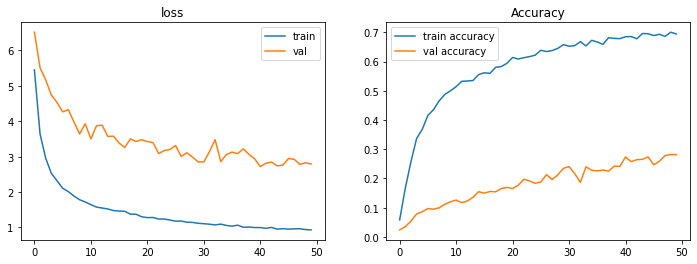

In [100]:
plot_history(history)

In [101]:
model.save('API_FTW')

2021-08-31 12:16:11.985250: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: API_FTW/assets
